In [1]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
folder_path = '/content/drive/MyDrive/Resumes_Docx'
os.listdir(folder_path)

['SQL Developer',
 'workday',
 'React Developer',
 'Peoplesoft Resume',
 'Peoplesoft']

In [3]:
!pip install pdfplumber python-docx docx2txt pytesseract pillow


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.8/67.8 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.0/60.0 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 69.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 253.0/253.0 kB 22.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 90.9 MB/s eta 0:00:00


In [4]:
!tesseract --version


tesseract 4.1.1
 leptonica-1.82.0
  libgif 5.1.9 : libjpeg 8d (libjpeg-turbo 2.1.1) : libpng 1.6.37 : libtiff 4.3.0 : zlib 1.2.11 : libwebp 1.2.2 : libopenjp2 2.4.0
 Found AVX2
 Found AVX
 Found FMA
 Found SSE
 Found libarchive 3.6.0 zlib/1.2.11 liblzma/5.2.5 bz2lib/1.0.8 liblz4/1.9.3 libzstd/1.4.8


In [6]:
import re
import nltk
import spacy
import string
import pandas as pd
import seaborn as sns
from matplotlib import pylab
from matplotlib import pyplot as plt

In [7]:
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from wordcloud import WordCloud, STOPWORDS
from nltk.stem import PorterStemmer, WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer

import warnings
warnings.filterwarnings('ignore')

In [8]:
os.listdir(folder_path)

['SQL Developer',
 'workday',
 'React Developer',
 'Peoplesoft Resume',
 'Peoplesoft']

In [9]:
import os
import pdfplumber
from docx import Document
import docx2txt


In [10]:
!apt-get install -y libreoffice


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  apparmor at-spi2-core default-jre default-jre-headless dictionaries-common
  firebird3.0-common firebird3.0-common-doc firebird3.0-server-core
  firebird3.0-utils fonts-crosextra-caladea fonts-crosextra-carlito
  fonts-dejavu fonts-dejavu-core fonts-dejavu-extra fonts-liberation2
  fonts-linuxlibertine fonts-noto-core fonts-noto-extra fonts-noto-mono
  fonts-noto-ui-core fonts-opensymbol fonts-sil-gentium
  fonts-sil-gentium-basic gsettings-desktop-schemas gstreamer1.0-gl
  gstreamer1.0-gtk3 gstreamer1.0-plugins-base hunspell-en-us libabsl20210324
  libabw-0.1-1 libatk-bridge2.0-0 libatk-wrapper-java libatk-wrapper-java-jni
  libatk1.0-0 libatk1.0-data libatspi2.0-0 libboost-filesystem1.74.0
  libboost-iostreams1.74.0 libboost-locale1.74.0 libboost-thread1.74.0
  libbsh-java libcdparanoia0 libcdr-0.1-1 libclucene-contribs1v5
  libclucen

In [11]:
import os
import subprocess

def convert_with_libreoffice(input_dir):
    for root, _, files in os.walk(input_dir):
        for file in files:
            if file.lower().endswith(('.doc', '.docx')):
                file_path = os.path.join(root, file)
                subprocess.run([
                    'libreoffice', '--headless',
                    '--convert-to', 'docx',
                    '--outdir', root,
                    file_path
                ], stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)

convert_with_libreoffice(folder_path)


In [12]:
def ocr_image_pdf(pdf_path):
    text = ""
    try:
        with pdfplumber.open(pdf_path) as pdf:
            for page in pdf.pages:
                img = page.to_image(resolution=200).original
                text += pytesseract.image_to_string(img)
    except:
        pass
    return text.strip()


In [ ]:
text = "" # Initialize text as an empty string
file_path = '/content/drive/MyDrive/Resumes_Docx/SQL Developer/sample_resume.pdf' # Provide a sample PDF path

# Now the original cell can run
if not text.strip():
    text = ocr_image_pdf(file_path)
print(text[:200]) # Print first 200 characters of extracted text to verify

In [14]:
def extract_text_from_pdf(file_path):
    text = ""
    try:
        with pdfplumber.open(file_path) as pdf:
            for page in pdf.pages:
                if page.extract_text():
                    text += page.extract_text() + " "
    except:
        pass
    return text.strip()


In [15]:
def extract_text_from_docx(file_path):
    try:
        doc = Document(file_path)
        text = " ".join([p.text for p in doc.paragraphs])
        if text.strip():
            return text
    except:
        pass

    # fallback for broken docx
    try:
        return docx2txt.process(file_path)
    except:
        return ""


In [16]:
data = []
failed_files = []

base_path = folder_path   # '/content/drive/MyDrive/Resumes_Docx'

for category in os.listdir(base_path):
    category_path = os.path.join(base_path, category)

    if not os.path.isdir(category_path):
        continue

    for file in os.listdir(category_path):
        file_path = os.path.join(category_path, file)
        text = ""

        try:
            if file.lower().endswith(".pdf"):
                text = extract_text_from_pdf(file_path)

            elif file.lower().endswith(".docx"):
                text = extract_text_from_docx(file_path)

            if text.strip():
                data.append({
                    "Category": category,
                    "Resume_Text": text
                })
            else:
                failed_files.append(file_path)

        except Exception as e:
            failed_files.append(file_path)


In [17]:
df = pd.DataFrame(data)
df.head()


,Category,Resume_Text
0,SQL Developer,SQL DEVELOPER Name: - Bandi prem sai Willi...
1,SQL Developer,Resu...
2,SQL Developer,B. vinod kumar OBJECTIVE: Willing to work und...
3,SQL Developer,KAMBALLA PRADEEP ...
4,SQL Developer,ANIL KUMAR MADDUKURI \t\t SQL & MSBI Develope...


In [18]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79 entries, 0 to 78
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Category     79 non-null     object
 1   Resume_Text  79 non-null     object
dtypes: object(2)
memory usage: 1.4+ KB


In [19]:
df['Category'].value_counts()


,count
Category,
React Developer,24
workday,21
Peoplesoft Resume,20
SQL Developer,14


In [20]:
df.isnull().sum()


,0
Category,0
Resume_Text,0


Category-wise distribution

In [21]:
category_counts = df['Category'].value_counts()
category_counts


,count
Category,
React Developer,24
workday,21
Peoplesoft Resume,20
SQL Developer,14


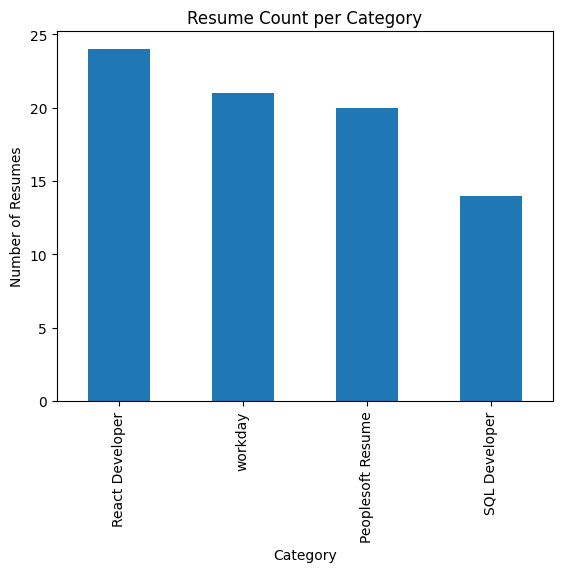

In [22]:
plt.figure()
category_counts.plot(kind='bar')
plt.title("Resume Count per Category")
plt.xlabel("Category")
plt.ylabel("Number of Resumes")
plt.show()


Resume length analysis

In [23]:
df['resume_length'] = df['Resume_Text'].apply(lambda x: len(x.split()))


In [24]:
df['resume_length'].describe()


,resume_length
count,79.000000
mean,626.126582
std,423.876082
min,19.000000
25%,350.500000
50%,515.000000
75%,800.500000
max,2458.000000


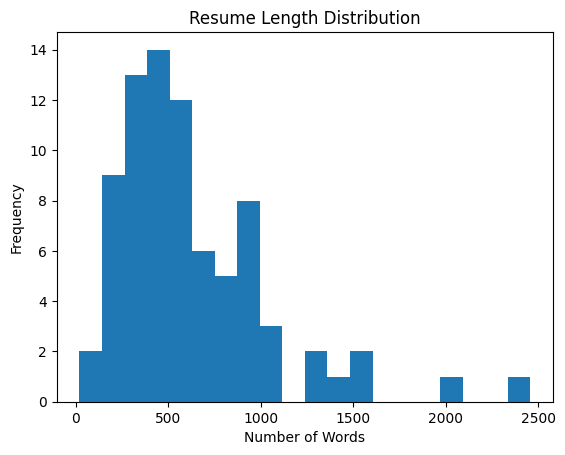

In [26]:
plt.figure()
plt.hist(df['resume_length'], bins=20)
plt.title("Resume Length Distribution")
plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.show()


Average resume length per category

In [27]:
df.groupby('Category')['resume_length'].mean().sort_values(ascending=False)


,resume_length
Category,
Peoplesoft Resume,846.850000
workday,791.142857
SQL Developer,570.428571
React Developer,330.291667


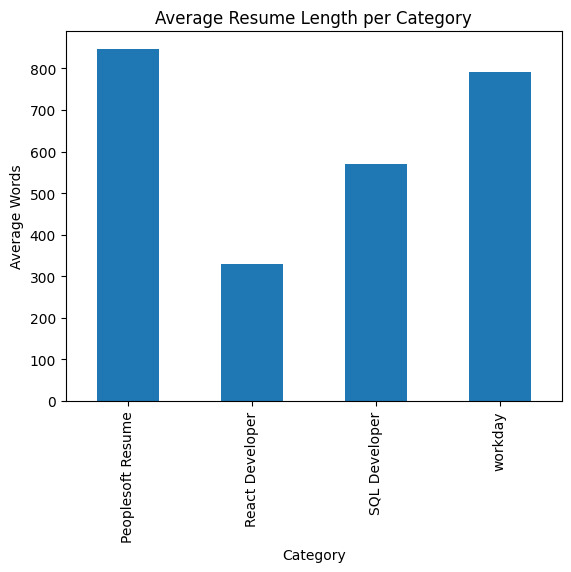

In [28]:
plt.figure()
df.groupby('Category')['resume_length'].mean().plot(kind='bar')
plt.title("Average Resume Length per Category")
plt.ylabel("Average Words")
plt.show()


Text cleaning

In [29]:
import re

def basic_clean(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z\s]', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

df['clean_text'] = df['Resume_Text'].apply(basic_clean)


Most common words

In [30]:
from collections import Counter

all_words = " ".join(df['clean_text']).split()
word_freq = Counter(all_words)

word_freq.most_common(20)


[('and', 2677),
 ('the', 1308),
 ('in', 1220),
 ('to', 1063),
 ('of', 939),
 ('on', 644),
 ('for', 617),
 ('experience', 564),
 ('with', 403),
 ('peoplesoft', 395),
 ('as', 390),
 ('using', 375),
 ('application', 369),
 ('workday', 367),
 ('server', 327),
 ('reports', 310),
 ('data', 304),
 ('a', 302),
 ('from', 297),
 ('project', 274)]

WordCloud

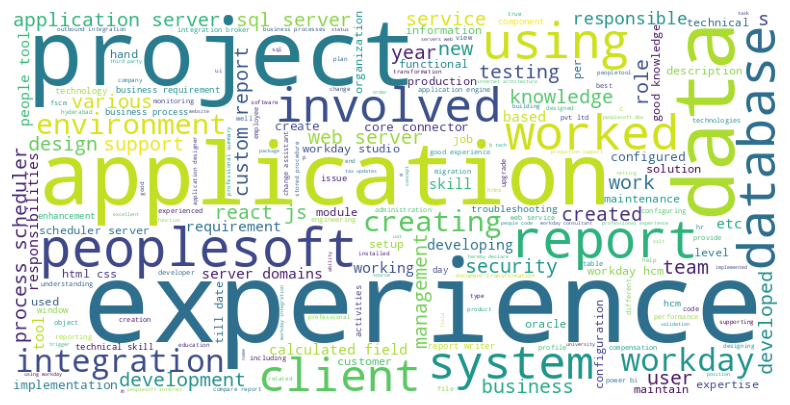

In [31]:
from wordcloud import WordCloud

text_data = " ".join(df['clean_text'])

wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white',
    stopwords=STOPWORDS
).generate(text_data)

plt.figure(figsize=(10,5))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()


Category-specific keywords

In [32]:
category = "React Developer"  # change as needed

text_cat = " ".join(df[df['Category'] == category]['clean_text'])
Counter(text_cat.split()).most_common(20)


[('and', 295),
 ('the', 216),
 ('in', 189),
 ('to', 147),
 ('of', 146),
 ('react', 126),
 ('js', 104),
 ('for', 97),
 ('on', 86),
 ('experience', 82),
 ('with', 77),
 ('using', 76),
 ('html', 76),
 ('a', 73),
 ('css', 66),
 ('project', 63),
 ('as', 61),
 ('knowledge', 57),
 ('is', 57),
 ('web', 56)]

In [34]:
df


,Category,Resume_Text,resume_length,clean_text
0,SQL Developer,SQL DEVELOPER Name: - Bandi prem sai Willi...,551,sql developer name bandi prem sai willing to w...
1,SQL Developer,Resu...,629,resume name neeraj mishra having year month of...
2,SQL Developer,B. vinod kumar OBJECTIVE: Willing to work und...,580,b vinod kumar objective willing to work under ...
3,SQL Developer,KAMBALLA PRADEEP ...,241,kamballa pradeep synopsis looking forward to a...
4,SQL Developer,ANIL KUMAR MADDUKURI \t\t SQL & MSBI Develope...,626,anil kumar maddukuri sql msbi developer summar...
...,...,...,...,...
74,Peoplesoft Resume,PeopleSoft Database Administrator ...,786,peoplesoft database administrator gangareddy p...
75,Peoplesoft Resume,Vinod Akkala ...,1575,vinod akkala peoplesoft dba admin professional...
76,Peoplesoft Resume,"Priyanka Ramadoss 61/46, MountPleasant, Coono...",488,priyanka ramadoss mountpleasant coonoor the ni...
77,Peoplesoft Resume,\t Profile Summary:\t\t\t\t\t\t\t\t\t\t...,987,profile summary years of experience in impleme...


Stopword Removal

In [36]:
import nltk
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))

def remove_stopwords(text):
    return " ".join([word for word in text.split() if word not in stop_words])

df['no_stopwords_text'] = df['clean_text'].apply(remove_stopwords)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Lemmatization

In [38]:
import nltk
nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()

def lemmatize_text(text):
    return " ".join([lemmatizer.lemmatize(word) for word in text.split()])

df['lemmatized_text'] = df['no_stopwords_text'].apply(lemmatize_text)

[nltk_data] Downloading package wordnet to /root/nltk_data...


Final Feature-Ready Text Column

In [39]:
df['final_text'] = df['lemmatized_text']


In [40]:
df[['Resume_Text', 'final_text']].head()


,Resume_Text,final_text
0,SQL DEVELOPER Name: - Bandi prem sai Willi...,sql developer name bandi prem sai willing work...
1,Resu...,resume name neeraj mishra year month experienc...
2,B. vinod kumar OBJECTIVE: Willing to work und...,b vinod kumar objective willing work challengi...
3,KAMBALLA PRADEEP ...,kamballa pradeep synopsis looking forward aspi...
4,ANIL KUMAR MADDUKURI \t\t SQL & MSBI Develope...,anil kumar maddukuri sql msbi developer summar...


The resume text has been fully preprocessed (cleaning, stopword removal, lemmatization) and is stored in the final_text column. This column is ready to be directly used for TF-IDF vectorization and classification model building. No further text cleaning is required from my side.